## Example: Names in the Wild

This example is drawn from Wes McKinney's excellent book on the *Pandas* library, O'Reilly's [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do).

We'll be taking a look at a freely available dataset: the database of names given to babies in the United States over the last century.

First things first, we need to download the data, which can be found at http://www.ssa.gov/oact/babynames/limits.html.
If you uncomment the following commands, it will do this automatically (note that these are linux shell commands; they will not work on Windows):

In [1]:
import pandas as pd
import numpy as np
import seaborn; seaborn.set()
%matplotlib inline

In [7]:
#!curl -O https://www.ssa.gov/oact/babynames/names.zip

/home/lohia/projects/pandas-tutorial


In [13]:
#!mkdir -p data/names
#!mv names.zip data/
!cd data/names/ && unzip names.zip

Archive:  names.zip
   creating: names/
  inflating: names/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/names/
  inflating: __MACOSX/names/._.DS_Store  
  inflating: names/NationalReadMe.pdf  
  inflating: names/yob1880.txt       
  inflating: names/yob1881.txt       
  inflating: names/yob1882.txt       
  inflating: names/yob1883.txt       
  inflating: names/yob1884.txt       
  inflating: names/yob1885.txt       
  inflating: names/yob1886.txt       
  inflating: names/yob1887.txt       
  inflating: names/yob1888.txt       
  inflating: names/yob1889.txt       
  inflating: names/yob1890.txt       
  inflating: names/yob1891.txt       
  inflating: names/yob1892.txt       
  inflating: names/yob1893.txt       
  inflating: names/yob1894.txt       
  inflating: names/yob1895.txt       
  inflating: names/yob1896.txt       
  inflating: names/yob1897.txt       
  inflating: names/yob1898.txt       
  inflating: names/yob1899.txt       
  inflating: names/yob1900.t

Now we should have a ``data/names`` directory which contains a number of text files, one for each year of data:

In [15]:
!ls data/names/

NationalReadMe.pdf  yob1907.txt  yob1935.txt  yob1963.txt  yob1991.txt
yob1880.txt	    yob1908.txt  yob1936.txt  yob1964.txt  yob1992.txt
yob1881.txt	    yob1909.txt  yob1937.txt  yob1965.txt  yob1993.txt
yob1882.txt	    yob1910.txt  yob1938.txt  yob1966.txt  yob1994.txt
yob1883.txt	    yob1911.txt  yob1939.txt  yob1967.txt  yob1995.txt
yob1884.txt	    yob1912.txt  yob1940.txt  yob1968.txt  yob1996.txt
yob1885.txt	    yob1913.txt  yob1941.txt  yob1969.txt  yob1997.txt
yob1886.txt	    yob1914.txt  yob1942.txt  yob1970.txt  yob1998.txt
yob1887.txt	    yob1915.txt  yob1943.txt  yob1971.txt  yob1999.txt
yob1888.txt	    yob1916.txt  yob1944.txt  yob1972.txt  yob2000.txt
yob1889.txt	    yob1917.txt  yob1945.txt  yob1973.txt  yob2001.txt
yob1890.txt	    yob1918.txt  yob1946.txt  yob1974.txt  yob2002.txt
yob1891.txt	    yob1919.txt  yob1947.txt  yob1975.txt  yob2003.txt
yob1892.txt	    yob1920.txt  yob1948.txt  yob1976.txt  yob2004.txt
yob1893.txt	    yob1921.txt  yob1949.txt  yob1977.txt  yob

Let's take a quick look at one of these files:

In [16]:
!head data/names/yob1880.txt

Each file is just a comma-separated list of names, genders, and counts of babies with that name in each year.

We can load these files using ``pd.read_csv``, which is specifically designed for this:

In [17]:
names1880 = pd.read_csv('data/names/yob1880.txt')
names1880.head()

,Mary,F,7065
0,Anna,F,2604
1,Emma,F,2003
2,Elizabeth,F,1939
3,Minnie,F,1746
4,Margaret,F,1578


Oops! Something went wrong. Our algorithm tried to be smart, and use the first line as index labels.
Let's fix this by specifying the index names manually:

In [18]:
names1880 = pd.read_csv('data/names/yob1880.txt',
                        names=['name', 'gender', 'births'])
names1880.head()

,name,gender,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


That looks better. Now we can start playing with the data a bit.

### GroupBy: aggregates on values

First let's think about how we might count the total number of females and males born in the US in 1880.

If you're used to NumPy, you might be tempted to use masking like this:

First, we can get a mask over all females & males, and then use it to select a subset of the data:

In [19]:
males = names1880[names1880.gender == 'M']
females = names1880[names1880.gender == 'F']

Now we can take the sum of the births for each of these:

In [20]:
males.births.sum(), females.births.sum()

(110490, 90992)

But there's an easier way to do this, using one of Pandas' very powerful features: ``groupby``:

In [21]:
grouped = names1880.groupby('gender')
grouped

This grouped object is now an abstract representation of the data, where the data is split on the given column.
In order to actually do something with this data, we need to specify an **aggregation** operation to do across the data.
In this case, what we want is the sum:

In [22]:
grouped.sum()

,births
gender,
F,90992
M,110490


We can do other aggregations as well:

In [23]:
grouped.size()

gender
F     942
M    1058
dtype: int64

In [24]:
grouped.mean()

,births
gender,
F,96.594480
M,104.432892


Or, if we wish, we can get a description of the grouping:

In [25]:
grouped.describe()

births
gender                   
F      count   942.000000
       mean     96.594480
       std     328.151887
       min       5.000000
       25%       7.000000
       50%      13.000000
       75%      43.750000
       max    7065.000000
M      count  1058.000000
       mean    104.432892
       std     561.216596
       min       5.000000
       25%       7.000000
       50%      12.000000
       75%      41.000000
       max    9655.000000

### Concatenating multiple data sources

But here we've just been looking at a single year. Let's try to put together all the data in all the years.
To do this, we'll have to use pandas ``concat`` function to concatenate all the data together.
First we'll create a function which loads the data as we did the above data:

In [26]:
def load_year(year):
    data = pd.read_csv('data/names/yob{0}.txt'.format(year),
                       names=['name', 'gender', 'births'])
    data['year'] = year
    return data

Now let's load all the data into a list, and call ``pd.concat`` on that list:

In [27]:
names = pd.concat([load_year(year) for year in range(1880, 2014)])
names.head()

,name,gender,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


It looks like we've done it!

Let's start with something easy: we'll use ``groupby`` again to see the total number of births per year:

In [28]:
births = names.groupby('year').births.sum()
births.head()

year
1880    201482
1881    192696
1882    221534
1883    216945
1884    243463
Name: births, dtype: int64

We can use the ``plot()`` method to see a quick plot of these (note that because we used the ``%matplotlib inline`` magic at the start of the notebook, the resulting plot will be shown inline within the notebook).

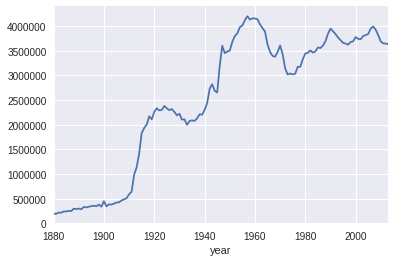

In [29]:
births.plot();

The so-called "baby boom" generation after the second world war is abundantly clear!

We can also use other aggregates: let's see *how many* names are used each year:

In [ ]:
names.groupby('year').births.count().plot();

Apparently there's been a huge increase of the diversity of names with time!

``groupby`` can also be used to add columns to the data: think of it as a *view* of the data that you're modifying. Let's add a column giving the frequency of each name within each year & gender:

In [ ]:
def add_frequency(group):
    group['birth_freq'] = group.births / group.births.sum()
    return group

names = names.groupby(['year', 'gender']).apply(add_frequency)
names.head()

Notice that the ``apply()`` function iterates over each group, and calls a function which modifies the group.
This result is then re-constructed into a container which looks ike the original dataframe.

### Pivot Tables

Next we'll discuss Pivot Tables, which are an even more powerful way of (re)organizing your data.

Let's say that we want to plot the men and women separately.
We could do this by using masking, as follows:

In [ ]:
men = names[names.gender == 'M']
women = names[names.gender == 'W']

And then we could proceed as above, using ``groupby`` to group on the year.
But we would end up with two different views of the data. A better way to do this is to use a ``pivot_table``, which is essentially a groupby in multiple dimensions at once:

In [ ]:
births = names.pivot_table('births',
                           index='year', columns='gender',
                           aggfunc=sum)
births.head()

Note that this has grouped the index by the value of ``year``, and grouped the columns by the value of ``gender``.
Let's plot the results now:

In [ ]:
births.plot(title='Total Births');

### Name Evolution Over Time

Some names have shifted from being girls names to being boys names. Let's take a look at some of these:

In [ ]:
names_to_check = ['Allison', 'Alison']

# filter on just the names we're interested in
births = names[names.name.isin(names_to_check)]

# pivot table to get year vs. gender
births = births.pivot_table('births', index='year', columns='gender')

# fill all NaNs with zeros
births = births.fillna(0)

# normalize along columns
births = births.div(births.sum(1), axis=0)

births.plot(title='Fraction of babies named Allison');

We can see that prior to about 1905, all babies named Allison were male. Over the 20th century, this reversed, until the end of the century nearly all Allisons were female!

There's some noise in this data: we can smooth it out a bit by using a 5-year rolling mean:

In [ ]:
births.rolling(window=5, center=False).mean().plot(title="Allisons: 5-year moving average");

This gives a smoother picture of the transition, and is an example of the bias/variance tradeoff that we'll often see in modeling: a smoother model has less variance (variation due to sampling or other noise) but at the expense of more bias (the model systematically mis-represents the data slightly).

We'll discuss this type of tradeoff more in coming sessions.